## Reproduction code for grid search

This notebook contains the code for reproducing the grid search results, and reproduces Figure 2 of the paper.

We start from loading the libraries necessary for running the code and load the test images.

In [ ]:
from numpy import *
import numpy as np
import time
svd = linalg.svd
randn = random.randn
import numba
from numba import njit
from pylab import *
ion()
import scipy
from scipy import ndimage

testmu = load("./data/UWDRO1_slice40_attenuation.npy")[::2,::2]*1.
testlambda = load("./data/UWDRO1_slice40_activity.npy")[::2,::2]*1.

We now set up the system. The details can be found in `noiseless-setting.ipynb`.

In [19]:
## Parameters of the images
totalcounts = 1.0e6 # expected total number of counts
nx = 128 
ny = 128
ximageside = 30.0   #cm
yimageside = 30.0   #cm
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([nx])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
fovmask = testlambda*0.
fovmask[rar<=ximageside/2.] = 1. #the fovmask confines the image to the largest inscribed circle of the image array
mumask = fovmask*1.

## Parameters of the detectors
radius = 100.0    #cm
detector1_to_detector2 = 200.0   #cm
nviews = 128
slen = pi     #angular range of the scan
nbins = 128
dtc = dx/16.
ntc = int(detector1_to_detector2/dtc)
tcshift = 0.5*(detector1_to_detector2 - ntc*dtc)
war = arange(radius-detector1_to_detector2+tcshift,radius,dtc)

## Time-of-flight information
fwhm = 9.0 #cm
tofspacing = fwhm/2.
toflen = ximageside+2*fwhm
toflen = minimum(toflen,detector1_to_detector2)
tofsig= fwhm/2.355
dtof = tofspacing
ntof = int(toflen/dtof)
toflen = ntof*dtof    #change the toflen so that it is a multiple of dtof
tof0 = -toflen/2.
tofmat = []
for i in range(ntof):
   w0 = (i+0.5)*dtof + tof0
   wfun = exp( -((war-w0)**2)/(2.*tofsig**2))
   tofmat.append(wfun)
tofmat = array(tofmat)

## Additional parameters
small = 1.e-10 # small constant to avoid numerical error


Next, we define some useful utility functions.

In [20]:
## function for forward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamProjection(wimage,sinogram, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   image = mask*wimage
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for backward projection
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamBackProjection(sinogram, image, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept
   image *= mask


## function for weighted forward projection
@njit(cache=True) # if computing projection multiple times use: @njit(cache=true)
def circularParallelBeamWProjection(image,sinogram, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.


   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensues ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+tofweight2*frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+tofweight2*frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for weighted backward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamWBackProjection(sinogram, image, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen*tofweight2
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen*tofweight2
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               ixOld=ix
               xIntOld=xIntercept


## functions for time-of-flight projection matrix multiplication

def TOFprojection(wimage,tofsino,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   tofsino.fill(0.)
   image = mask*wimage
   for i in range(ntof):
      circularParallelBeamWProjection(image,tofsino[i],tofmat[i])


def TOFbackProjection(tofsino,image,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   image.fill(0.)
   wim = image*0.
   for i in range(ntof):
      circularParallelBeamWBackProjection(tofsino[i],wim,tofmat[i])
      image += wim
   image *= mask

## utility functions for saatv-admm

#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad


def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim


def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w


def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w



The count data is generated and rescaled such that the total number of counts is $1.0\times 10^6$. The details can also be found in `noiseless-setting.ipynb`.

In [21]:
sinogram=zeros([nviews,nbins],"float64")   
sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)

tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)

truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level

tofdata *= datafactor
tofsino *= datafactor
testlambda  *= datafactor
truess *= datafactor

We specify the nuclear norm of the projection matrices, and the parameters for the optimization problem.

In [44]:
ltofproj = 23.1500763
lproj =27.89508541
numu= 9.92287722
nulam= 8.23497622
ltotmu = 27.973308258
ltotlam = 23.24406084
niter = 101
newtiter = 10
nuv = 100
resultsfile='./results/grid_search_datarmse_'

The following code executes the coarse grid search, where $(\rho_{\mu},\rho_{\sigma}) \in \{10^{-4},  10^{-3},10^{-2}, 10^{-1},1,10,10^2,10^3,10^4\} \times (\rho_{\mu},\rho_{\sigma}) \in \{10^{-4},  10^{-3},10^{-2}, 10^{-1},1,10,10^2,10^3,10^4\}$.

In [ ]:
## coarse grid search
dgrid=[]
for sbmu in [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]:
   dgridrow = []
   for sblambda in [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]:
      sigmu = sbmu/lproj
      taumu = 1.0/(sbmu*lproj)

      siglambda = sblambda/ltofproj
      taulambda = 1.0/(sblambda*ltofproj)
      print("sblambda: ",sblambda," sbmu: ",sbmu)

      worktofsino = 0.*tofsino
      ulambda = 0.*tofsino
      ylambda = 0.*tofsino

      imlambda = testlambda*0.
      wimlambda = testlambda*0.

      worksino = 0.*sinoatt
      umu = 0.*sinoatt
      ymu = 0.*sinoatt

      immu = testmu*0.
      wimmu = testmu*0.

      datarmses = []
      for j in range(niter):
# x-update
         TOFprojection(imlambda,worktofsino)
         arg1 = ulambda+siglambda*(worktofsino -ylambda)
         TOFbackProjection(arg1,wimlambda)

# counts constraint block
         nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum())/fovmask.sum()

         imlambda =imlambda -taulambda*(nu*fovmask + wimlambda)
         TOFprojection(imlambda,worktofsino)


         circularParallelBeamProjection(immu,worksino)
         arg1 = umu +sigmu*( worksino -ymu )
         circularParallelBeamBackProjection(arg1,wimmu)
         immu =immu - wimmu*taumu
         immu *= mumask
         circularParallelBeamProjection(immu,worksino)

         ylambdat = 1.*ylambda
         ymut = 1.*ymu
# y-update
         aq = siglambda #biconvex
         cq = -tofdata
         for k in range(nuv):
            ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
            bq = ymuterm - ulambda - siglambda*worktofsino # biconvex
            ylambdaold = ylambda*1.
            ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
            ylambdaold = ylambda*1.

            ymunewt = ymu*0.
            for i in range(newtiter):
               grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino) #biconvex
               ymuterm = ylambdaold*exp(-ymunewt)
               hess = ymuterm.sum(axis=0) + sigmu #biconvex
               ymunewt = ymunewt - grad/hess
            ymuold = ymu*1.
            ymu = ymunewt*1.
            ymu[ymu<0.] = 0.
            ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
            ymudist = sqrt( ( (ymu-ymuold)**2).sum())
   
# u-update
         TOFprojection(imlambda,worktofsino)
         ulambda = ulambda + siglambda*(worktofsino - ylambda)

         circularParallelBeamProjection(immu,worksino)
         umu = umu +sigmu*(worksino-ymu)

         datarmse = sqrt(( (tofdata-worktofsino*exp(-worksino))**2. ).sum())/sqrt(1.*ntof*nviews*nbins)
         imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt(1.*nx*ny)
         imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt(1.*nx*ny)
         datarmses.append(datarmse)

      dgridrow.append(datarmse)
   dgrid.append(dgridrow)

save(resultsfile+"coarse.npy",array(dgrid))

The following code plots the coarse grid search results, and reproduces the top of Figure 2.

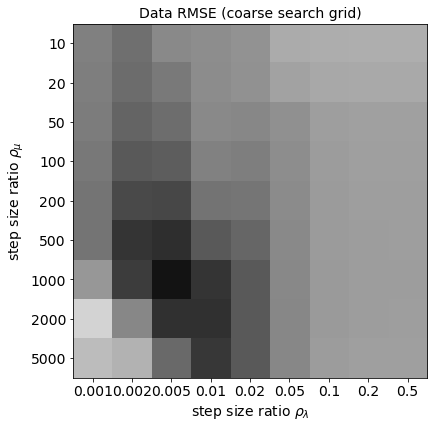

In [51]:
d = log(np.load("./results/grid_search_datarmse_coarse.npy"))/log(10.0)

figure(1,figsize=(6,6))
imshow(d,vmin = -1.0,vmax=2.0,interpolation="nearest",cmap = cm.gray)
xtlabels=["0.001","0.002","0.005","0.01","0.02","0.05","0.1","0.2","0.5"]
xtvals = range(9)
ytlabels=["10","20","50","100","200","500","1000","2000","5000"]
ytvals = range(9)
xticks(xtvals,xtlabels,fontsize=14)
yticks(ytvals,ytlabels,fontsize=14)

xlabel(r"step size ratio $\rho_\lambda$",fontsize=14)
ylabel(r"step size ratio $\rho_\mu$",fontsize=14)
title("Data RMSE (coarse search grid)",fontsize=14)

subplots_adjust(left=0.15,bottom=0.08,top=0.95,right=0.97)



Next, we conduct a fine grid search, where $\rho_{\mu} \in \{10,20,50,100,200,500,1000,2000,5000\}$ and $\rho_{\lambda}\in\{0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5\}$.

In [ ]:
## fine grid search

dgrid=[]
for sbmu in [10.,20.,50.,100.,200.,500.,1000.,2000.,5000.]:
   dgridrow = []
   for sblambda in [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5]:
      sigmu = sbmu/lproj
      taumu = 1.0/(sbmu*lproj)

      siglambda = sblambda/ltofproj
      taulambda = 1.0/(sblambda*ltofproj)
      print("sblambda: ",sblambda," sbmu: ",sbmu)

      worktofsino = 0.*tofsino
      ulambda = 0.*tofsino
      ylambda = 0.*tofsino

      imlambda = testlambda*0.
      wimlambda = testlambda*0.

      worksino = 0.*sinoatt
      umu = 0.*sinoatt
      ymu = 0.*sinoatt

      immu = testmu*0.
      wimmu = testmu*0.

      datarmses = []
      for j in range(niter):
# x-update
         TOFprojection(imlambda,worktofsino)
         arg1 = ulambda+siglambda*(worktofsino -ylambda)
         TOFbackProjection(arg1,wimlambda)

# counts constraint block
         nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum())/fovmask.sum()

         imlambda =imlambda -taulambda*(nu*fovmask + wimlambda)
         TOFprojection(imlambda,worktofsino)


         circularParallelBeamProjection(immu,worksino)
         arg1 = umu +sigmu*( worksino -ymu )
         circularParallelBeamBackProjection(arg1,wimmu)
         immu =immu - wimmu*taumu
         immu *= mumask
         circularParallelBeamProjection(immu,worksino)

         ylambdat = 1.*ylambda
         ymut = 1.*ymu
# y-update
         aq = siglambda #biconvex
         cq = -tofdata
         for k in range(nuv):
            ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
            bq = ymuterm - ulambda - siglambda*worktofsino # biconvex
            ylambdaold = ylambda*1.
            ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
            ylambdaold = ylambda*1.

            ymunewt = ymu*0.
            for i in range(newtiter):
               grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino) #biconvex
               ymuterm = ylambdaold*exp(-ymunewt)
               hess = ymuterm.sum(axis=0) + sigmu #biconvex
               ymunewt = ymunewt - grad/hess
            ymuold = ymu*1.
            ymu = ymunewt*1.
            ymu[ymu<0.] = 0.
            ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
            ymudist = sqrt( ( (ymu-ymuold)**2).sum())
   
# u-update
         TOFprojection(imlambda,worktofsino)
         ulambda = ulambda + siglambda*(worktofsino - ylambda)

         circularParallelBeamProjection(immu,worksino)
         umu = umu +sigmu*(worksino-ymu)

         datarmse = sqrt(( (tofdata-worktofsino*exp(-worksino))**2. ).sum())/sqrt(1.*ntof*nviews*nbins)
         imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt(1.*nx*ny)
         imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt(1.*nx*ny)
         datarmses.append(datarmse)

      dgridrow.append(datarmse)
   dgrid.append(dgridrow)

save(resultsfile+"fine.npy",array(dgrid))



Finally, we plot the fine grid search result and reproduce the bottom of Figure 2.

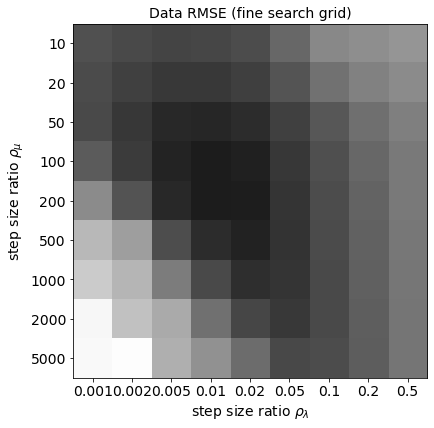

In [38]:
d = log(np.load("./results/grid_search_datarmse_fine.npy"))/log(10.0)

figure(1,figsize=(6,6))
imshow(d,vmin = -1.0,vmax=1.0,interpolation="nearest",cmap = cm.gray)
xtlabels=["0.001","0.002","0.005","0.01","0.02","0.05","0.1","0.2","0.5"]
xtvals = range(9)
ytlabels=["10","20","50","100","200","500","1000","2000","5000"]
ytvals = range(9)
xticks(xtvals,xtlabels,fontsize=14)
yticks(ytvals,ytlabels,fontsize=14)

xlabel(r"step size ratio $\rho_\lambda$",fontsize=14)
ylabel(r"step size ratio $\rho_\mu$",fontsize=14)
title("Data RMSE (fine search grid)",fontsize=14)

subplots_adjust(left=0.15,bottom=0.08,top=0.95,right=0.97)
